In [1]:
import os
import numpy as np

In [29]:
import string_constants as sc
import reading_util as ru
import plotting_util as pu
import analysis_plotting_util as apu
import quantile_regression_dnn as qr
import parameter as pa
import gof_hypothesis_test as hyptest
import dataset_util as du

# set runtime parameters

In [3]:
# share of total qcd signal region data for QR training (rest for GOF test)
QR_train_share = 0.25 #0.2
quantile = pa.quantile_dict['q1'] # q1 = 1%
strategy = pa.loss_strategy_dict['s5'] # s5 = L1 & L2

In [4]:
regr_cut = True

In [5]:
fig_dir_base = 'fig/analysis_goodness_of_fit/regression' + ('_cut' if regr_cut else '_full')
!mkdir -p $fig_dir_base

# read in qcd data

In [17]:
SM_sample = 'qcdSigAll'

qcd_path = os.path.join( sc.concat_result_dir, sc.sample_loc[SM_sample] + sc.concat_result_suffix )
qcd_data_total = ru.read_results_to_dataframe( qcd_path )

## split qcd data into train and test set 

In [30]:
qcd_n_evts = qcd_data_total.shape[0]
qcd_data_train, qcd_data_test = du.split_dataset_train_test( qcd_data_total, QR_train_share )

In [31]:
print('training on ' + str(qcd_data_train.shape[0]) + ' events')
print('testing on ' + str(qcd_data_test.shape[0]) + ' events')

training on 1317390 events
testing on 3952171 events


## plot qcd mass spectrum for training set and testing set

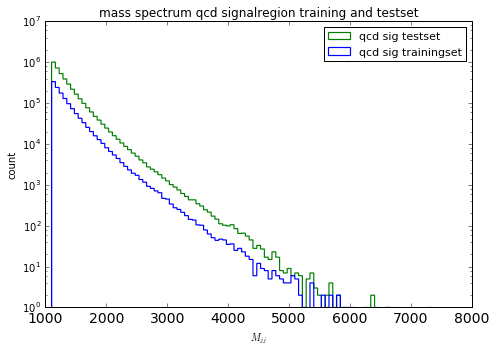

In [32]:
_ = pu.plot_hist( [qcd_data_train['mJJ'], qcd_data_test['mJJ']], xlabel=r'$M_{jj}$', \
                 legend=['qcd sig trainingset','qcd sig testset'], normed=False, ylabel='count', \
                 title='mass spectrum qcd signalregion training and testset')

# read in signal data and populate sample dictionary

In [21]:
BSM_samples = ['GtoWW15na', 'GtoWW20na', 'GtoWW25na', 'GtoWW30na', 'GtoWW35na', 'GtoWW40na', 'GtoWW45na', \
              'GtoWW15br', 'GtoWW20br', 'GtoWW25br', 'GtoWW30br', 'GtoWW35br', 'GtoWW40br', 'GtoWW45br']
all_samples = [SM_sample] + BSM_samples

result_data = {}

result_data[SM_sample] = qcd_data_test

for n in BSM_samples:
    sample = ru.read_results_to_dataframe( os.path.join( sc.concat_result_dir, sc.sample_loc[n] + sc.concat_result_suffix ) )
    print(n,": ",sample.shape[0],"events")
    result_data[n] = sample

('GtoWW15na', ': ', 448032, 'events')
('GtoWW20na', ': ', 477149, 'events')
('GtoWW25na', ': ', 512505, 'events')
('GtoWW30na', ': ', 530775, 'events')
('GtoWW35na', ': ', 488137, 'events')
('GtoWW40na', ': ', 530031, 'events')
('GtoWW45na', ': ', 432356, 'events')
('GtoWW15br', ': ', 394521, 'events')
('GtoWW20br', ': ', 446043, 'events')
('GtoWW25br', ': ', 472902, 'events')
('GtoWW30br', ': ', 486192, 'events')
('GtoWW35br', ': ', 498566, 'events')
('GtoWW40br', ': ', 503838, 'events')
('GtoWW45br', ': ', 517498, 'events')


## plot losses

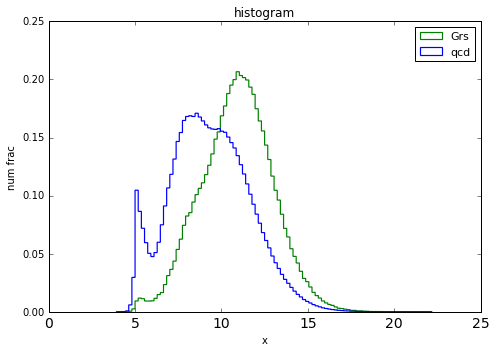

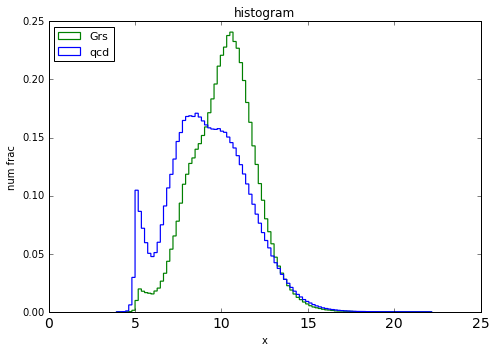

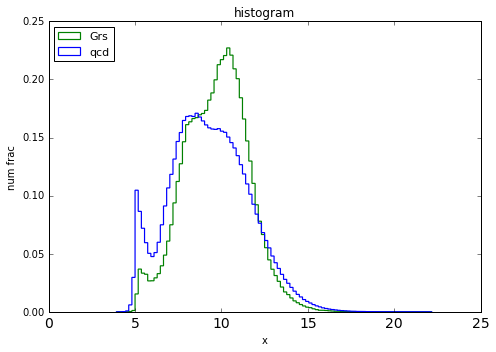

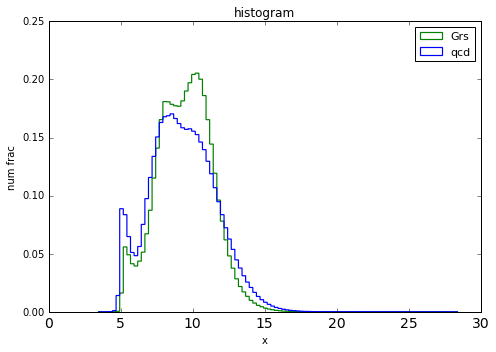

In [76]:
import plotting_util as pu
sig_samples = ['GtoWW15br','GtoWW25br','GtoWW35br','GtoWW45br']
for sig in sig_samples:
    qcd_var = np.sum([result_data['qcdSigAll']['j1KlLoss'],result_data['qcdSigAll']['j2KlLoss']],axis=0)
    grs_var = np.sum([result_data[sig]['j1KlLoss'],result_data[sig]['j2KlLoss']],axis=0)
    _ = pu.plot_hist([qcd_var,grs_var],legend=['qcd','Grs'],ylogscale=False)

# Train QR DNN

In [33]:
# train QR
combined_loss = strategy( qcd_data_train )
model = qr.Quantile_Regression( quantile.val )
model.fit( qcd_data_train['mJJ'].values, combined_loss )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               200       
_________________________________________________________________
dense_14 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_15 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_16 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_17 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 101       
Total para

# get regression cut point

In [34]:
# get overflow bin (max accepted mjj) for regression cut
sel = model.select_events( qcd_data_train['mJJ'].values, combined_loss ) # get selection for qcd training set
max_acc_mjj = np.max(qcd_data_train['mJJ'][sel]) # get max mjj in accepted set

In [35]:
max_acc_mjj

4340.08740234375

In [36]:
acc = qcd_data_train['mJJ'][sel].values
print(np.sort(acc)[-5:])
rej = qcd_data_train['mJJ'][np.logical_not(sel)]
print(np.sort(rej)[-5:])

[3670.37646484 3919.40209961 4107.81738281 4338.15380859 4340.08740234]
[5836.01757812 5857.92529297 5944.32861328 5980.51171875 6613.49902344]


# plot mass vs loss with loss-cut prediction for qcd train data

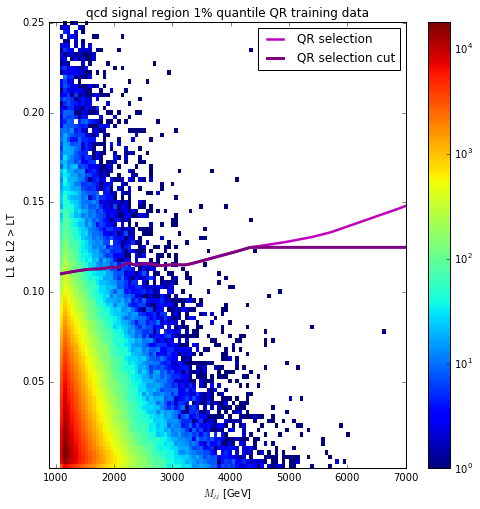

In [37]:
apu.plot_qr_2d_hist( qcd_data_train, combined_loss, model, quantile, strategy, max_acc_mjj=max_acc_mjj )

## plot mass spectrum accepted vs rejected qcd train

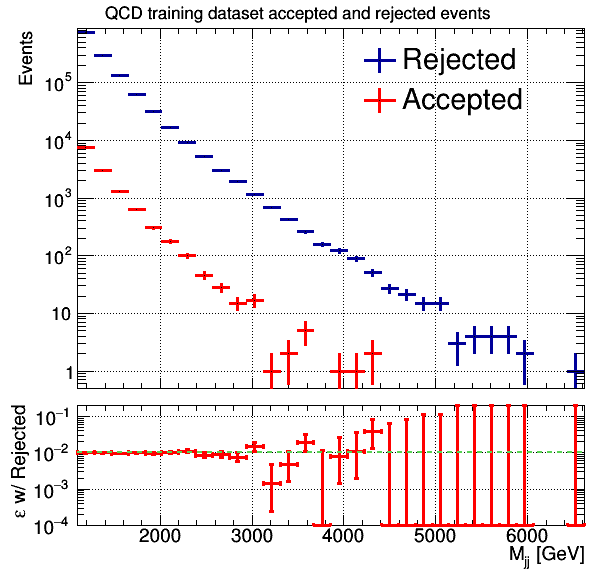

In [38]:
binning=[30, pa.Mjj_selection, qcd_data_train['mJJ'].max()]
c = apu.plotMassSpectrum(qcd_data_train['mJJ'][sel], qcd_data_train['mJJ'][np.logical_not(sel)], binning, quantile.val, 'QCD training dataset accepted and rejected events')
h_a = c.h_list[1]
h_r = c.h_list[0]
#c.SaveAs(os.path.join(fig_dir,'qcd_train_mjj_selected_vs_rejected_hist.png'))

## do hypothesis test on qcd training data

('S obs:', 60.86759427424728)
Test stat reached after 1 loops


0.3198

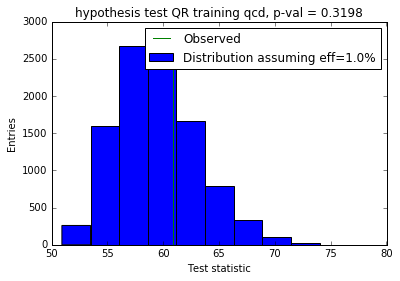

In [39]:
reload(hyptest)
hyptest.HypotesisTets(h_a, h_r, quantile.val, N_asymov=10000)

# Analyze signal data

In [73]:
BSM_samples = ['GtoWW15na', 'GtoWW20na', 'GtoWW25na', 'GtoWW30na', 'GtoWW35na', 'GtoWW40na', 'GtoWW45na', \
              'GtoWW15br', 'GtoWW20br', 'GtoWW25br', 'GtoWW30br', 'GtoWW35br', 'GtoWW40br', 'GtoWW45br']
all_samples = [SM_sample] + BSM_samples

In [74]:
result_data = {}

result_data[SM_sample] = qcd_data_total[int(qcd_n_evts*QR_train_share):] # all of qcd already read in, take test share 

for n in BSM_samples:
    sample, labels = ru.read_results_to_recarray( os.path.join( sc.concat_result_dir, sc.sample_loc[n] + sc.concat_result_suffix ) )
    print(n,": ",sample.shape[0],"events")
    result_data[n] = sample

('GtoWW15na', ': ', 448032, 'events')
('GtoWW20na', ': ', 477149, 'events')
('GtoWW25na', ': ', 512505, 'events')
('GtoWW30na', ': ', 530775, 'events')
('GtoWW35na', ': ', 488137, 'events')
('GtoWW40na', ': ', 530031, 'events')
('GtoWW45na', ': ', 432356, 'events')
('GtoWW15br', ': ', 394521, 'events')
('GtoWW20br', ': ', 446043, 'events')
('GtoWW25br', ': ', 472902, 'events')
('GtoWW30br', ': ', 486192, 'events')
('GtoWW35br', ': ', 498566, 'events')
('GtoWW40br', ': ', 503838, 'events')
('GtoWW45br', ': ', 517498, 'events')
